<a href="https://colab.research.google.com/github/hetvi0609/ML_Assignment3/blob/main/Q7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastbook


In [ ]:
from fastbook import *
def search_images_ddg_corrected(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        try:
            data = urljson(requestUrl,data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(0.2)
    return L(urls)

In [ ]:
urls1 = search_images_ddg_corrected('Sachin Tendulkar', max_images=40)
urls2 = search_images_ddg_corrected('Harbhajan Singh', max_images=40)
for i in range(40):
    print(i)
    name1="train/Sachin/"+str(i)+".jpg"
    download_url(urls1[i], name1)
    name2="train/Harbhajan/"+str(i)+".jpg"
    download_url(urls2[i], name2)
  

In [ ]:
# load dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = 'train/'
photos, labels = list(), list()
print(folder)
# enumerate files in the directory
print(listdir(folder))
for file in listdir(folder):
  if(file=="Harbhajan" or file=="Sachin"):
    for i in range(40):
      name=file+"/"+str(i)+".jpg"
      print(name)
      # determine class
      output = 0.0
      if file.startswith('Harbhajan'):
        output = 1.0
      # load image
      photo = load_img(folder + name, target_size=(200, 200))
      # convert to numpy array
      photo = img_to_array(photo)
      # store
      photos.append(photo)
      labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('Sachin_vs_Harbhajan_photos.npy', photos)
save('Sachin_vs_Harbhajan_labels.npy', labels)


In [ ]:
from numpy import load
import imageio
photos = load('Sachin_vs_Harbhajan_photos.npy')
labels = load('Sachin_vs_Harbhajan_labels.npy')
print(photos.shape, labels.shape)
print(labels)
for i in range(40):
  if(labels[i]==1):
    imageio.imwrite("train/Harbhajan/"+str(i)+".jpg", photos[i].astype(np.uint8))
    # im = Image.fromarray((photos[i] * 255).astype(np.uint8))
    # im.save("train/Harbhajan/"+str(i)+".jpg")
  elif(labels[i]==0):
    imageio.imwrite("train/Sachin/"+str(i)+".jpg", photos[i].astype(np.uint8))
    # im = Image.fromarray((photos[i] * 255).astype(np.uint8))
    # im.save("train/Sachin/"+str(i)+".jpg")

In [ ]:

# load dataset, reshape and save to a new file
from os import listdir,makedirs

# create directories
dataset_home = 'Dataset_Sachin_vs_Harbhajan/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['Sachin/', 'Harbhajan/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [ ]:

# baseline model 
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_Sachin_vs_Harbhajan/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_Sachin_vs_Harbhajan/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 35.000


In [ ]:
# baseline model with data augmentation
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_Sachin_vs_Harbhajan/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_Sachin_vs_Harbhajan/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 50.000


In [ ]:
# vgg16 model used for transfer learning on the dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_Sachin_vs_Harbhajan/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset_Sachin_vs_Harbhajan/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

58892288/58889256 [==============================] - 1s 0us/step
Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1/1 [==============================] - 24s 24s/step - loss: 6.5751 - accuracy: 0.5167 - val_loss: 11.7949 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 23s 23s/step - loss: 4.9189 - accuracy: 0.7333 - val_loss: 10.6693 - val_accuracy: 0.5500
Epoch 3/10
1/1 [==============================] - 23s 23s/step - loss: 0.6359 - accuracy: 0.9500 - val_loss: 10.3451 - val_accuracy: 0.6500
Epoch 4/10
1/1 [==============================] - 23s 23s/step - loss: 0.0394 - accuracy: 0.9833 - val_loss: 9.6183 - val_accuracy: 0.6500
Epoch 5/10
1/1 [==============================] - 23s 23s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 9.2773 - val_accuracy: 0.8000
Epoch 6/10
1/1 [==============================] - 23s 23s/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 9.6700 - val_accuracy: 0.8000
Epoch 7/10
1/1 [==============================] - 23s 23s/step - loss: 7.6665e-05 - accuracy: 1.0000 - val_loss: 9.9549 - val_accuracy: 0.8000
Epoch 8/10
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 80.000


In [ ]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
# create directories
dataset_home = 'finalize_Sachin_vs_Harbhajan/'
# create label subdirectories
labeldirs = ['Sachin/', 'Harbhajan/']
for labldir in labeldirs:
	newdir = dataset_home + labldir
	makedirs(newdir, exist_ok=True)
# copy training dataset images into subdirectories
src_directory = 'dataset_Sachin_vs_Harbhajan/train/'
for file in listdir(src_directory):
  if(file=="Harbhajan" or "Sachin"):
    name_dir=src_directory+file
    print(name_dir)
    for i in listdir(name_dir):
      print(i)
      src=name_dir+"/"+i
      dst = dataset_home + file +"/"+i
      copyfile(src, dst)
      

dataset_Sachin_vs_Harbhajan/train/Sachin
14.jpg
9.jpg
15.jpg
3.jpg
7.jpg
19.jpg
22.jpg
2.jpg
4.jpg
0.jpg
16.jpg
8.jpg
21.jpg
28.jpg
27.jpg
23.jpg
18.jpg
17.jpg
13.jpg
24.jpg
1.jpg
20.jpg
10.jpg
26.jpg
29.jpg
5.jpg
6.jpg
25.jpg
12.jpg
11.jpg
dataset_Sachin_vs_Harbhajan/train/Harbhajan
14.jpg
9.jpg
15.jpg
3.jpg
7.jpg
19.jpg
22.jpg
2.jpg
4.jpg
0.jpg
16.jpg
8.jpg
21.jpg
28.jpg
27.jpg
23.jpg
18.jpg
17.jpg
13.jpg
24.jpg
1.jpg
20.jpg
10.jpg
26.jpg
29.jpg
5.jpg
6.jpg
25.jpg
12.jpg
11.jpg


In [ ]:
# save the final model to file
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('finalize_Sachin_vs_Harbhajan/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
	# save model
	model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

Found 60 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


[1.]


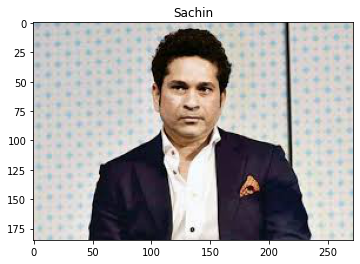

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as img

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

# load an image and predict the class
def run_example():
	# load the image
	img = load_image('sample1_image.jpeg')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	result = model.predict(img)
	return (result[0])

# entry point, run the example
result=run_example()
result1=run_example()
print(result)
if(result==0):   
    # reading the image
    testImage = img.imread('sample1_image.jpeg')
    # displaying the image
    imgplot=plt.imshow(testImage)
    plt.title("Harbhajan")
    plt.show()
else:
    # reading the image
    testImage = img.imread('sample1_image.jpeg')
    # displaying the image
    imgplot=plt.imshow(testImage)
    plt.title("Sachin")
    plt.show()